In [1]:
# Load basic modules.
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

In [2]:
# Add the (custom) source code file in the path.
module_path = os.path.abspath(os.path.join('../../src/'))

if module_path not in sys.path:
    sys.path.append(module_path)
# _end_if_

In [3]:
# Load custom modules.
from var_bayes.free_energy import FreeEnergy
from dynamical_systems.lorenz_63 import Lorenz63
from numerical.symbolics import get_local_polynomials

In [4]:
# Drift parameter vector.
theta = np.array([10.0, 28.0, 2.66667])

# Diffusion noise parameter vector.
sigma = np.array([10.0, 10.0, 10.0])

# Create a Lorenz63 object.
L3D = Lorenz63(sigma, theta, r_seed=180)

In [5]:
# Time-window of inference T = [t0, tf] with step = dt.
t0, tf, dt = 0.0, 20.0, 0.01

# Make a trajectory (discrete sample path).
L3D.make_trajectory(t0, tf, dt)

# Observation density.
nobs = 4

# Collect the (noise free) observations.
obs_idk, obs_val = L3D.collect_obs(nobs)

# Number of observations.
num_M = obs_val.shape[0]

In [6]:
# Observation noise (variance).
obs_noise = np.array([2.0, 2.0, 2.0])

# Add Gaussian I.I.D. noise to the observations.
obs_val += np.sqrt(obs_noise) * L3D.rng.standard_normal(obs_val.shape)

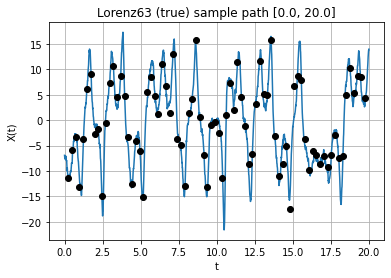

In [7]:
# Quick sample path plot.
plt.plot(L3D.tk, L3D.xt[:, 0])
plt.plot(obs_idk*dt, obs_val[:, 0], 'ko')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title(f"Lorenz63 (true) sample path [{t0}, {tf}]")
plt.grid(True)

In [8]:
# Note: If it happens to have observations at the initial and final
# times (i.e. t0, tf), then we do not need to extend the following
# vectors "spl_timex" and "spl_value".

# Build the spline with these parameters.
spl_timex = np.array([t0,
                      *(obs_idk*dt),
                      tf])

spl_value = np.array([obs_val[0],
                      *obs_val,
                      obs_val[-1]])

# Initialize list.
x0 = []

# Create the initial sample path (t=0) using
# cubic B-splines at the noisy observations.
for i in range(3):
    
    B_spline_cubic = splrep(spl_timex, spl_value[:, 0], k=3)
    x0.append(splev(L3D.tk, B_spline_cubic))
# _end_for_

# Convert to numpy array.
x0 = np.array(x0)

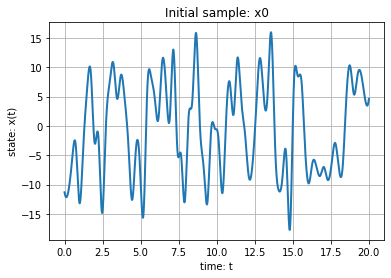

In [9]:
plt.plot(L3D.tk, x0[0], linewidth=2)
plt.title("Initial sample: x0")
plt.xlabel("time: t")
plt.ylabel("state: x(t)")
plt.grid(True)

In [10]:
# This time space is in index-units.
time_space = [0, *obs_idk, len(x0)-1]

mp_idk = []
sp_idk = []

for n, tn in enumerate(time_space):
    
    # Avoids out of bounds.
    if tn == time_space[-1]:
        break
    # _end_if_
    
    # Take every 4 instances.
    mp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=4, endpoint=True, dtype=int))
    
    # Take every 3 instances.
    sp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=3, endpoint=True, dtype=int))
# _end_for_

# Remove the duplicates (at observation points).
mp_idk = np.unique(mp_idk)
sp_idk = np.unique(sp_idk)

In [11]:
# Initial mean points.
mp_t0 = x0[:, mp_idk]

# Initialize variance points.
sp_t0 = 0.25 * np.ones((3, len(sp_idk)))

# Put the variance in log-space.
sp_t0 = np.log(sp_t0)

In [12]:
# Initial prior moments for N(mu0, tau0).
mu0 = np.ones(3)
tau0 = 0.25 * np.ones(3)

# Create a FreeEnergy object.
free_energy = FreeEnergy(L3D, mu0, tau0, obs_idk*dt, obs_val, obs_noise)

In [ ]:
# Run the optimization.
opt_res = free_energy.find_minimum(np.concatenate((mp_t0.flatten(order='C'),
                                                   sp_t0.flatten(order='C')), axis=0),
                                   maxiter=250, check_gradients=True, verbose=True)

Grad-Check |BEFORE| minimization ...


In [ ]:
# Unpack the optimization results.
opt_x, opt_fx, opt_stats = opt_res

In [ ]:
# Plot the energy values.
plt.semilogx(opt_stats["fx"][0:opt_stats["MaxIt"]])
plt.title("$E_{total}$")
plt.xlabel("number of iterations")
plt.ylabel("$E_{total}(i)$")
plt.grid();

In [ ]:
# Get the mean points.
mp_tf = opt_x[0:mp_t0.size]

# Get the variance points. Remember that they
# are in log-space so here we have to use exp().
sp_tf = np.exp(opt_x[mp_t0.size:])

In [ ]:
# Get the lambda functions of the polynomials.
fun_mean_, fun_vars_ = get_local_polynomials()

In [ ]:
# Reshape the mean/var parametes.
mp_tf = np.reshape(mp_tf, (3, (3*num_M + 4)))
sp_tf = np.reshape(sp_tf, (3, (2*num_M + 3)))

In [ ]:
# Empty lists for the output functions.
tt, mt, st = [], [], []

# This time space is in time-units.
Tx = [t0, *(dt*obs_idk), tf]

# Reconstruct the mean and variance functions.
for n in range(0, len(Tx)-1):
    
    # Take the limits of the time interval.
    ti, tj = Tx[n], Tx[n+1]
        
    # It should be the same for equally spaced oservations.
    delta_t = np.abs(tj-ti)
    
    # Spacing variables fot the polynomials.
    h = float(delta_t/3.0)
    c = float(delta_t/2.0)
    
    # Extract variables for efficiency.
    nth_mean_points = mp_tf[:, (3 * n): (3 * n) + 4]
    nth_vars_points = sp_tf[:, (2 * n): (2 * n) + 3]
    
    # Since the functions are continous we can generate
    # as many m(t) and s(t) as we want. Here we collect
    # num points.
    for t in np.linspace(ti, tj, num=80, endpoint=False):

        mt_ = []
        st_ = []
        
        for i in range(3):
            
            # Prepare the parameters of the Lagrange polynomials.
            par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points[i]]
            par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points[i]]
    
            mt_.append(fun_mean_(t, *par_m))
            st_.append(fun_vars_(t, *par_s))
        # _end_for_
        
        mt.append(mt_)
        st.append(st_)
        tt.append(t)
        
    # _end_for_
    
# _end_for_


mt_ = []
st_ = []

# Add the final point 'tf'.
for i in range(3):
            
    # Prepare the parameters of the Lagrange polynomials.
    par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points[i]]
    par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points[i]]

    mt_.append(fun_mean_(tf, *par_m))
    st_.append(fun_vars_(tf, *par_s))
# _end_for_

mt.append(mt_)
st.append(st_)
tt.append(tf)

In [ ]:
# Convert everything to numpy arrays.
tt = np.array(tt)
mt = np.array(mt)
st = np.array(st)

In [ ]:
dim_ = 0

# Sample mean.
plt.plot(tt, mt[:, dim_], 'k-', label="m(t)", linewidth=1)

# Sample 2xStd (filled envelope).
plt.fill_between(tt, mt[:, dim_] - 2.0*np.sqrt(st[:, dim_]), mt[:, dim_] + 2.0*np.sqrt(st[:, dim_]),
                 label="s(t)", color="gray")

# Noisy observations.
plt.plot(obs_idk*dt, obs_val[:, dim_], 'ro', markersize=3, label="noisy obs.")

# Title and more.
plt.title("Lorenz63 process")
plt.xlabel("time: t")
plt.ylabel("state: x(t)")
plt.grid(True)
plt.legend(loc= "best");